# Code

In [1]:
%pip install PyGithub python-dotenv pandas tqdm matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from github import Github
import pandas as pd
from dotenv import load_dotenv
from os import getenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed


In [3]:
ORGANIZATIONS = ["googlesamples", "aws-samples", "Azure-Samples", "spring-guides", "googlearchive", "spring-cloud-samples"]
# ORGANIZATIONS = ["googlesamples"]
EXCLUDED_REPOS = [
    "googlearchive/digits-migration-helper-android",
    "googlearchive/play-apk-expansion",
    "googlearchive/tiger",
    "googlearchive/two-token-sw",
    "googlearchive/Abelana-Android",
    "googlearchive/solutions-mobile-backend-starter-java"
]

In [4]:
load_dotenv()
github_client = Github(getenv('GITHUB_TOKEN'))

In [5]:
def fetch_organization_repositories(organization_name, language=None):
    organization = github_client.get_organization(organization_name)
    repositories = organization.get_repos("all")
    total_repositories = repositories.totalCount
    repo_data = []

    def process_repo(repo):
        if repo.full_name in EXCLUDED_REPOS:
            return None

        if organization_name == "googlearchive" and not is_valid_googlearchive_repo(repo):
            return None
        elif organization_name == "SAP-samples" and not is_valid_sap_sample_repo(repo):
            return None

        repo_languages = repo.get_languages()
        total_lines = sum(repo_languages.values())
        language_percentages = {lang: f'{(lines/total_lines):.2%}' for lang, lines in repo_languages.items()}
        return {
            "full_name": repo.full_name,
            "name": repo.name,
            "owner": repo.owner.login,
            "html_url": repo.html_url,
            "description": repo.description,
            "language": repo.language,
            "created_at": repo.created_at,
            "updated_at": repo.updated_at,
            "pushed_at": repo.pushed_at,
            "size": repo.size,
            "stargazers_count": repo.stargazers_count,
            "watchers_count": repo.watchers_count,
            "forks_count": repo.forks_count,
            "open_issues_count": repo.open_issues_count,
            "open_issues_count": repo,
            "subscribers_count": repo.subscribers_count,
            "network_count": repo.network_count,
            "archived": repo.archived,
            "total_lines": total_lines,
            "langs_percentage": language_percentages
        }

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_repo, repo) for repo in repositories]
        for future in tqdm(as_completed(futures), desc=organization_name, unit=" repos", total=total_repositories, ncols=100):
            result = future.result()
            if result:
                repo_data.append(result)
                
    return pd.DataFrame(repo_data)

def is_valid_googlearchive_repo(repo):
    if not repo.description:
        return False
    keywords = ["example", "sample", "migrated"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)

def is_valid_sap_sample_repo(repo):
    if not repo.description:
        return False
    keywords = ["cloud"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)


In [6]:
def generate_metrics_csv():
    all_repos_data = []
    
    def fetch_data_for_organization(organization):
        print(f'Retrieving repos from {organization}...')
        organization_repos_data = fetch_organization_repositories(organization)
        if not organization_repos_data.empty:
            return organization_repos_data
        else:
            return pd.DataFrame()

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(fetch_data_for_organization, org) for org in ORGANIZATIONS]
        for future in tqdm(as_completed(futures), desc="Processing organizations", unit=" orgs"):
            org_data = future.result()
            if not org_data.empty:
                all_repos_data.append(org_data)

    all_repos_data_df = pd.concat(all_repos_data, ignore_index=True) if all_repos_data else pd.DataFrame()

    file_path = "results/codesamples.csv"
    all_repos_data_df.to_csv(file_path, index=False)

    return all_repos_data_df

In [7]:
def calculate_language_usage(dataframe):
    language_usage = {}

    for repo in dataframe.itertuples():
        repo_languages = repo.langs_percentage
        total_lines = repo.total_lines

        for language, percentage in repo_languages.items():
            lines = total_lines * (float(percentage.strip('%')) / 100)
            language_usage[language] = language_usage.get(language, 0) + lines

    total_lines_of_code = sum(language_usage.values())

    formatted_languages = sorted(
        [(language, f'{(lines / total_lines_of_code):.2%}', int(lines)) for language, lines in language_usage.items()],
        key=lambda item: float(item[1].strip('%')),
        reverse=True
    )

    file_path = f"results/languages_usage.csv"
    dataframeLanguages = pd.DataFrame(formatted_languages, columns=["Language", "Usage Percentage", "Lines"])
    dataframeLanguages.to_csv(file_path, index=False)
    return dataframeLanguages


In [16]:
def generate_statistics(dataframe):
    numeric_metrics = dataframe[METRICS].select_dtypes(include='number')
    
    statistics = numeric_metrics.describe().transpose()
    
    statistics['median'] = numeric_metrics.median()
    statistics['mode'] = numeric_metrics.mode().iloc[0]
    
    file_path = f"results/statistics.csv"
    statistics.to_csv(file_path)
    
    return statistics

In [9]:
def plot_metrics_distribution():
    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(METRICS):
        plt.subplot(3, 3, i + 1)
        sns.histplot(dataframe[metric], kde=True, bins=30, color='blue', alpha=0.6)
        plt.axvline(dataframe[metric].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
        plt.axvline(dataframe[metric].median(), color='g', linestyle='dashed', linewidth=1, label='Median')
        plt.title(f'Distribution of {metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.savefig('results/distribution_metrics.png')
    plt.show()

In [24]:
def plot_boxplot_metrics(dataframe):
    # Verificar se as colunas especificadas em METRICS são numéricas
    numeric_metrics = dataframe[METRICS].select_dtypes(include='number')
    
    plt.figure(figsize=(16, 12))
    for i, metric in enumerate(numeric_metrics.columns):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(x=numeric_metrics[metric], color='lightblue')
        plt.title(f'Boxplot of {metric}')
        plt.xlabel(metric)
    
    plt.tight_layout()
    plt.savefig('results/boxplot_metrics.png')
    plt.show()

In [19]:
def plot_metrics_distribution(dataframe):
    # Verificar se as colunas especificadas em METRICS são numéricas
    numeric_metrics = dataframe[METRICS].select_dtypes(include='number')
    
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(numeric_metrics.columns):
        plt.subplot(3, 3, i + 1)
        sns.histplot(numeric_metrics[metric], kde=True, bins=30, color='blue', alpha=0.6)
        plt.axvline(numeric_metrics[metric].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
        plt.axvline(numeric_metrics[metric].median(), color='g', linestyle='dashed', linewidth=1, label='Median')
        plt.title(metric)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('results/metrics_distribution.png')
    plt.show()

# Results

In [12]:
METRICS = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines'
]

In [13]:
dataframe = generate_metrics_csv()
dataframe

Retrieving repos from googlesamples...
Retrieving repos from aws-samples...
Retrieving repos from Azure-Samples...
Retrieving repos from spring-guides...
Retrieving repos from googlearchive...
Retrieving repos from spring-cloud-samples...


Processing organizations: 0 orgs [00:00, ? orgs/s]










spring-cloud-samples: 100%|█████████████████████████████████████| 29/29 [00:03<00:00,  7.58 repos/s]
Processing organizations: 1 orgs [00:05,  5.94s/ orgs]






















googlesamples: 100%|████████████████████████████████████████████| 71/71 [00:03<00:00, 20.24 repos/s]
Processing organizations: 2 orgs [00:08,  3.83s/ orgs]

spring-guides: 100%|████████████████████████████████████████████| 74/74 [00:03<00:00, 23.40 repos/s]
Request GET /repos/aws-samples/amazon-sagemaker-optuna-hpo-blog/languages failed with 403: Forbidden
Retrying after 60 seconds
Request GET /repos/Azure-Samples/resources-dotnet-deploy-using-arm-template-with-progress/languages failed with 403: Forbidden
Retrying after 60 seconds
Request GET /repos/aws-samples/aws-cloudhsm-on-aws-lambda-sample/languages failed with 403: Forbidden
Retrying after 60 seconds
Request GET /repos/aws-samples/aws-cloudformation-apigw-sap-idocs/languages failed with 403: Fo

,full_name,name,owner,html_url,description,language,created_at,updated_at,pushed_at,size,stargazers_count,watchers_count,forks_count,open_issues_count,subscribers_count,network_count,archived,total_lines,langs_percentage
0,spring-cloud-samples/configserver,configserver,spring-cloud-samples,https://github.com/spring-cloud-samples/config...,None,Java,2014-07-20 16:20:55+00:00,2024-06-18 14:33:03+00:00,2022-03-09 20:45:29+00:00,113,371,371,393,"Repository(full_name=""spring-cloud-samples/con...",28,393,False,2033,"{'Java': '90.01%', 'Dockerfile': '9.99%'}"
1,spring-cloud-samples/spring-cloud-gateway-sample,spring-cloud-gateway-sample,spring-cloud-samples,https://github.com/spring-cloud-samples/spring...,Sample Spring Cloud Gateway Application,Java,2017-10-13 16:41:13+00:00,2024-07-27 06:24:56+00:00,2021-12-07 20:03:34+00:00,79,360,360,231,"Repository(full_name=""spring-cloud-samples/spr...",15,231,False,5990,{'Java': '100.00%'}
2,spring-cloud-samples/spring-cloud-contract-nod...,spring-cloud-contract-nodejs-external-contracts,spring-cloud-samples,https://github.com/spring-cloud-samples/spring...,External contracts for the Spring Cloud Contra...,Java,2018-03-15 15:42:55+00:00,2021-04-26 15:04:54+00:00,2021-04-26 15:04:51+00:00,60,1,1,4,"Repository(full_name=""spring-cloud-samples/spr...",3,4,False,3798,{'Java': '100.00%'}
3,spring-cloud-samples/feign-eureka,feign-eureka,spring-cloud-samples,https://github.com/spring-cloud-samples/feign-...,Example of using feign with eureka,Java,2015-01-07 19:43:47+00:00,2024-06-17 16:52:09+00:00,2024-06-17 17:23:13+00:00,120,233,233,164,"Repository(full_name=""spring-cloud-samples/fei...",17,164,False,2288,{'Java': '100.00%'}
4,spring-cloud-samples/spring-cloud-config-vault,spring-cloud-config-vault,spring-cloud-samples,https://github.com/spring-cloud-samples/spring...,Sample application demonstrating how to use Ha...,Java,2018-10-29 23:17:57+00:00,2024-02-18 22:56:13+00:00,2021-04-26 15:09:18+00:00,66,16,16,16,"Repository(full_name=""spring-cloud-samples/spr...",4,16,False,1999,{'Java': '100.00%'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9299,aws-samples/webapp-form-builder,webapp-form-builder,aws-samples,https://github.com/aws-samples/webapp-form-bui...,This solution was built to accelerate the deve...,TypeScript,2024-07-31 09:59:45+00:00,2024-08-05 13:55:42+00:00,2024-07-31 10:20:56+00:00,84,6,6,0,"Repository(full_name=""aws-samples/webapp-form-...",2,0,False,34753,"{'TypeScript': '97.68%', 'JavaScript': '1.25%'..."
9300,aws-samples/sample-code-for-a-secure-vault-usi...,sample-code-for-a-secure-vault-using-aws-nitro...,aws-samples,https://github.com/aws-samples/sample-code-for...,AWS Nitro Enclaves Vault,Python,2024-07-31 18:35:59+00:00,2024-08-05 13:41:11+00:00,2024-08-05 13:42:12+00:00,1260,3,3,1,"Repository(full_name=""aws-samples/sample-code-...",7,1,False,153960,"{'Python': '54.09%', 'Rust': '33.80%', 'Docker..."
9301,aws-samples/deploy-langfuse-on-ecs-with-fargate,deploy-langfuse-on-ecs-with-fargate,aws-samples,https://github.com/aws-samples/deploy-langfuse...,Hosting Langfuse on Amazon ECS with Fargate us...,Python,2024-08-01 23:14:45+00:00,2024-08-05 13:37:41+00:00,2024-08-05 13:37:37+00:00,770,7,7,2,"Repository(full_name=""aws-samples/deploy-langf...",2,2,False,18834,"{'Python': '97.68%', 'Batchfile': '2.32%'}"
9302,aws-samples/rds-cross-region-snapshot,rds-cross-region-snapshot,aws-samples,https://github.com/aws-samples/rds-cross-regio...,None,None,2024-08-01 07:25:04+00:00,2024-08-02 03:01:50+00:00,2024-08-01 12:25:26+00:00,218,1,1,0,"Repository(full_name=""aws-samples/rds-cross-re...",1,0,False,0,{}


In [14]:
dataframeLanguages = calculate_language_usage(dataframe)
dataframeLanguages

,Language,Usage Percentage,Lines
0,Jupyter Notebook,32.59%,975553878
1,Python,23.91%,715609433
2,C,12.38%,370639616
3,JavaScript,7.01%,209750069
4,HTML,5.31%,158878071
...,...,...,...
143,QMake,0.00%,0
144,SmPL,0.00%,0
145,ABAP,0.00%,52354
146,Astro,0.00%,4980


In [17]:
dataframe_statistics = generate_statistics(dataframe)
dataframe_statistics

,count,mean,std,min,25%,50%,75%,max,median,mode
size,9304.0,8921.435189,4.770867e+04,0.0,64.0,407.0,2551.75,1965261.0,407.0,10
stargazers_count,9304.0,37.437124,1.913049e+02,0.0,2.0,6.0,19.00,9842.0,6.0,1
watchers_count,9304.0,37.437124,1.913049e+02,0.0,2.0,6.0,19.00,9842.0,6.0,1
forks_count,9304.0,30.300301,1.912637e+02,0.0,1.0,4.0,13.00,8302.0,4.0,0
subscribers_count,9304.0,15.606621,6.579950e+01,0.0,3.0,8.0,17.00,4563.0,8.0,2
network_count,9304.0,36.609523,3.961251e+02,0.0,1.0,4.0,13.00,23206.0,4.0,0
total_lines,9304.0,321739.061801,3.357340e+06,0.0,7040.5,23894.5,83974.25,185625162.0,23894.5,0


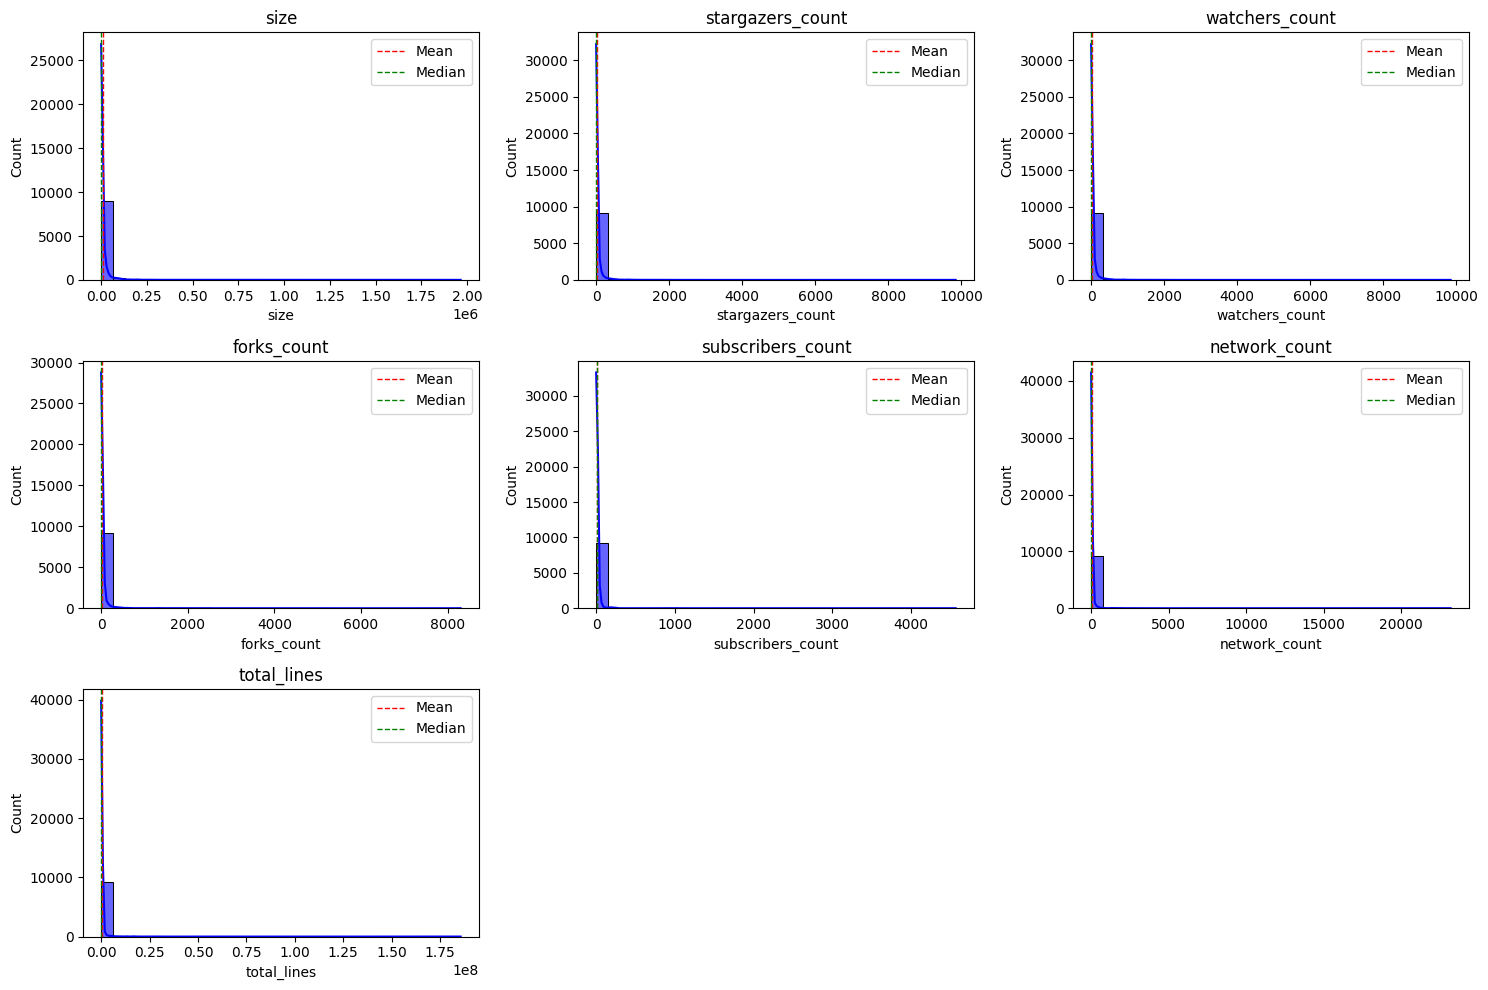

In [22]:
plot_metrics_distribution(dataframe)

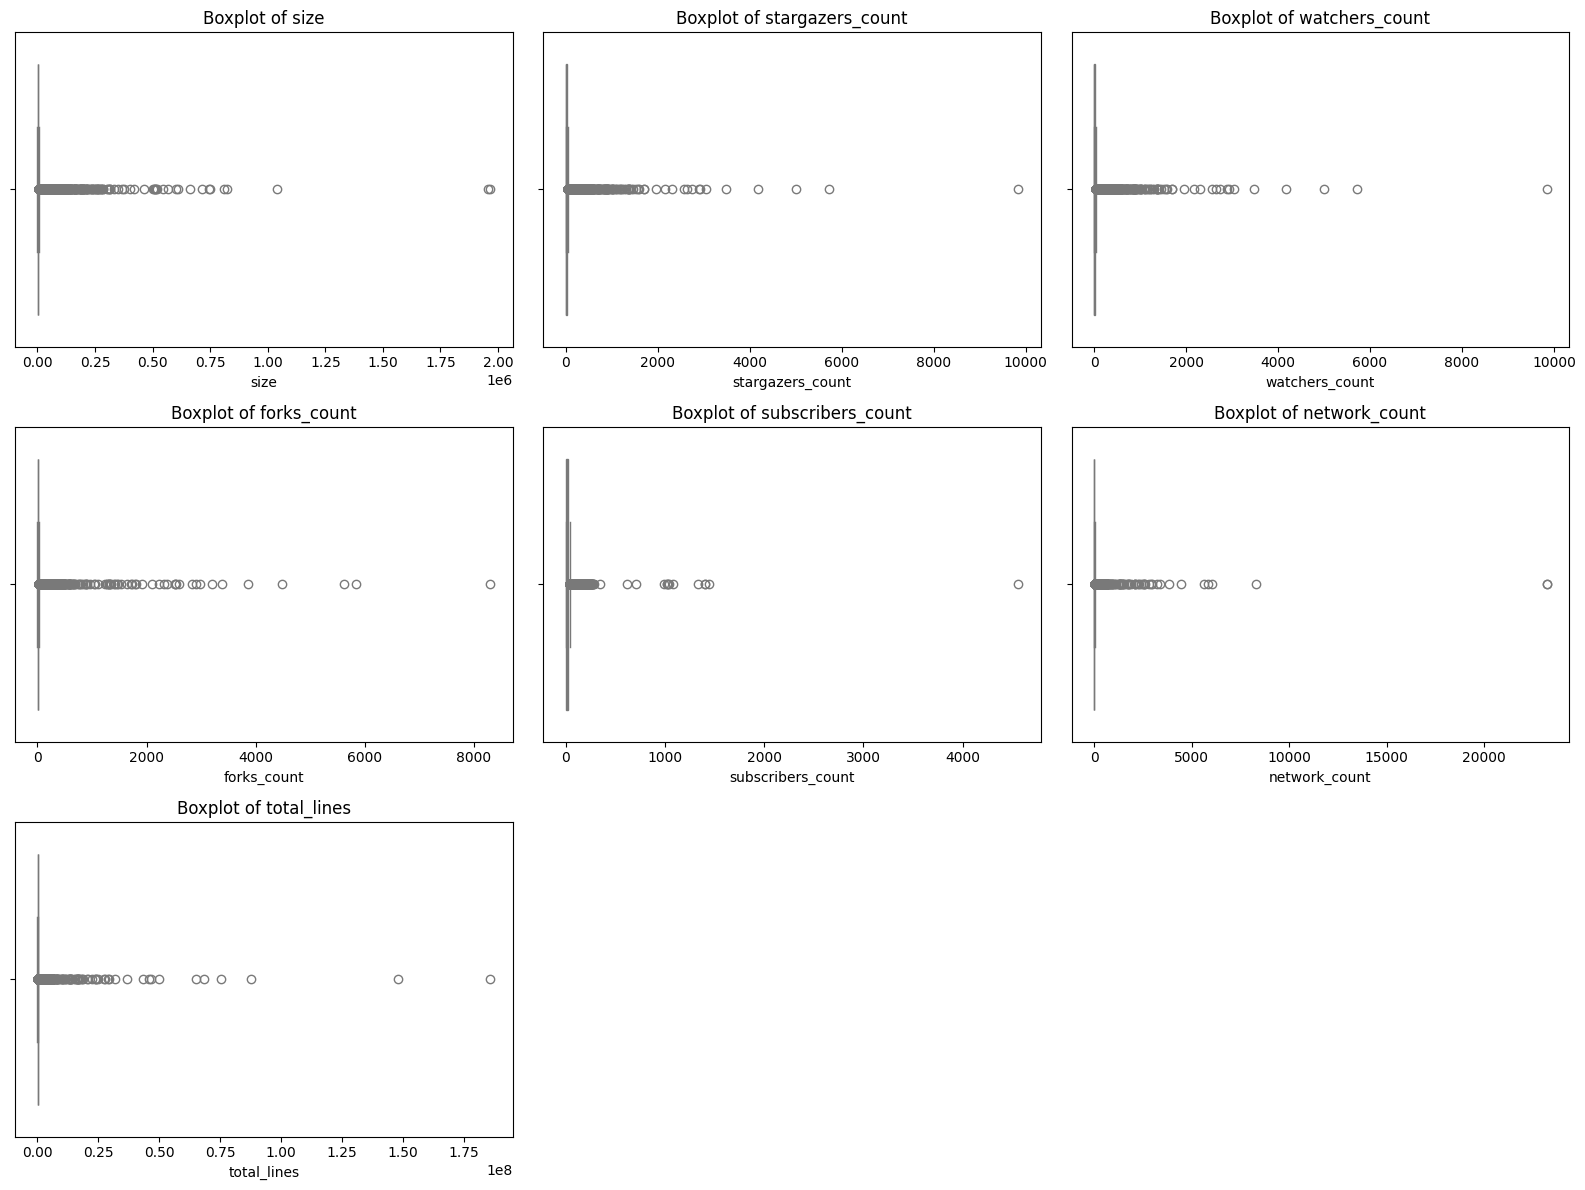

In [26]:
plot_boxplot_metrics(dataframe)

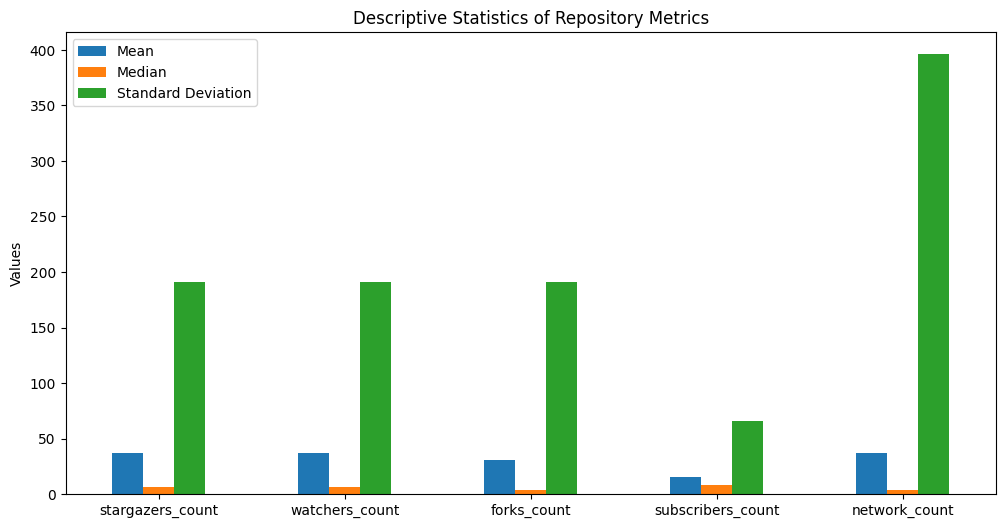

In [27]:
plot_metrics_statistics()